In [1]:
# import system modules
import sys
import os
os.system('for a in /sys/bus/pci/devices/*; do echo 0 | tee -a $a/numa_node>/dev/null; done') # get rid of NUMA node warnings: https://github.com/tensorflow/tensorflow/issues/42738


# import standard numerical modules
import numpy as np
import math


# import machine learning modules
import tensorflow as tf
import keras.backend as K
# make sure GPU usage is enabled
print(tf.config.list_physical_devices('GPU'))


# import DCTR
# path_to_DCTR = './' # uncomment and modify if needed
import DCTR


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# load data

In [2]:
# directory with pre converted lhe files as numpy arrays
data_dir = './Data' # modify as needed


In [3]:
# Load pre-normed Datasets for training: MiNNLO: X1 | POWHEG hvq: X0

# every particle has arguments: 
# [pt, rapidity, phi, mass, eta, E, PID, w, theta]
# [0 , 1       , 2  , 3   , 4  , 5, 6  , 7, 8    ]

X0_nrm = []
X1_nrm = []


# POWHEG hvq
X0_nrm = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/14TeV/normed_lhe.npz', i=3)[:int(1e7)] # only load first 10 million events for training
print(f'POWHEG hvq X0_nrm.shape: {X0_nrm.shape}')


# MiNNLO
X1_nrm = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_14TeV_NLO/normed_lhe.npz', i=3)
print(f'MiNNLO     X1_nrm.shape:  {X1_nrm.shape}')



POWHEG hvq X0_nrm.shape: (10000000, 3, 9)
MiNNLO     X1_nrm.shape:  (9553938, 3, 9)


In [4]:
# delete extra observables not needed for training

# delete Energy
X0_nrm = np.delete(X0_nrm, 5, -1)
X1_nrm = np.delete(X1_nrm, 5, -1)

# delete eta (pseudorpaidity) 
X0_nrm = np.delete(X0_nrm, 4, -1)
X1_nrm = np.delete(X1_nrm, 4, -1)


# prep data for training

In [5]:
# prep arrays for the neural network
''' prep_arrays() necessary args:
X0, X1
default args:
val=0.15, shuffle=True, use_class_weights=False
'''

# strips theta parameter from datasets and creates Y classifier arrays
# strips wgts from datasets and creates wgt arrays | if use_class_weights==True: -> give over represented dataset smaller weights 
# splits arrays into training and validation datasets accroding to val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0_nrm, X1_nrm, val=0.2)


2024-03-28 12:05:32.026424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 12:05:32.350356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6091 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



# train DCTR neural network

In [6]:
# setup DCTR neural network
''' default setup_nn() args:
input_dim=5, Phi_sizes = (100,100,128), F_sizes = (100,100,100),
loss = 'cce', dropout=0.0, l2_reg=0.0, Phi_acts='relu', F_acts='relu', output_act='softmax',
learning_rate=0.001, patience=10, use_scheduler=True, monitor='val_loss', reduceLR = True,
mode='min', savePath=currentPath, saveLabel='DCTR_training', summary=False, verbose = 2
'''

dctr, callbacks = DCTR.setup_nn(saveLabel='DCTR_training_14TeV', loss='mse', patience=35, learning_rate=0.001, use_scheduler=False)


Epoch 1/350

Epoch 1: val_loss improved from inf to 0.21706, saving model to /tf/home/gdrive/_STUDIUM_/DCTR_Paper/DCTR_training_14TeV.tf


2024-03-28 12:05:39.847407: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tf/home/gdrive/_STUDIUM_/DCTR_Paper/DCTR_training_14TeV.tf/assets
60/60 - 7s - loss: 0.2338 - acc: 0.5297 - val_loss: 0.2171 - val_acc: 0.5446 - lr: 0.0010 - 7s/epoch - 124ms/step
Epoch 2/350

Epoch 2: val_loss improved from 0.21706 to 0.21572, saving model to /tf/home/gdrive/_STUDIUM_/DCTR_Paper/DCTR_training_14TeV.tf
INFO:tensorflow:Assets written to: /tf/home/gdrive/_STUDIUM_/DCTR_Paper/DCTR_training_14TeV.tf/assets
60/60 - 6s - loss: 0.2162 - acc: 0.5475 - val_loss: 0.2157 - val_acc: 0.5502 - lr: 0.0010 - 6s/epoch - 100ms/step
Epoch 3/350

Epoch 3: val_loss improved from 0.21572 to 0.21500, saving model to /tf/home/gdrive/_STUDIUM_/DCTR_Paper/DCTR_training_14TeV.tf
INFO:tensorflow:Assets written to: /tf/home/gdrive/_STUDIUM_/DCTR_Paper/DCTR_training_14TeV.tf/assets
60/60 - 6s - loss: 0.2152 - acc: 0.5521 - val_loss: 0.2150 - val_acc: 0.5534 - lr: 0.0010 - 6s/epoch - 102ms/step
Epoch 4/350

Epoch 4: val_loss improved from 0.21500 to 0.21434, savin

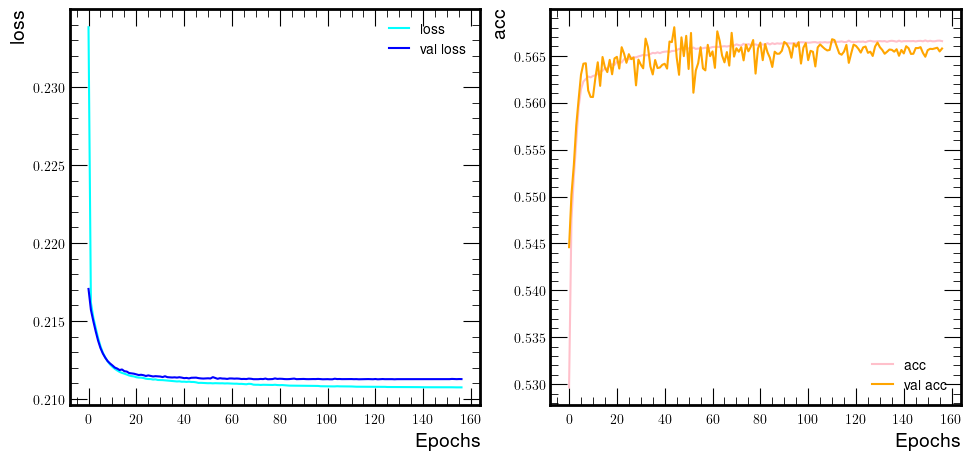

0.21074137091636658

In [7]:
# train DCTR neural network
''' train() necessary args:
dctr, callbacks, X_train, Y_train, X_val, Y_val
default args: 
wgt_train=1.0, wgt_val=1.0, epochs=80, batch_size=8192, savePath=currentPath, saveLabel='DCTR_training', verbose = 2, plot=True
'''

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, batch_size=8192*32, saveLabel='DCTR_training_14TeV', epochs=350)


In [8]:
# training took ~30min on RTX 2080 Super with 8GB VRAM


# load training and predict weights

In [9]:
# clear training data from memory
K.clear_session()
del X0_nrm, X1_nrm, X_train, X_val, Y_train, Y_val, wgt_train, wgt_val


In [10]:
# load testing datasets for reweighting

# POWHEG hvq, loading all events. Only first 10 million were used for training
X0_test = []
# args: filePath, i=number of particles to load
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/14TeV/converted_lhe.npz', i=3) # i=number of particles to load 3: top, anti-top, tt-pair
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))


# normed events for calculating reweighting; Energy and eta were not used for training
X0_nrm = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/14TeV/normed_lhe.npz', i=3)
# delete Energy and eta
X0_nrm = np.delete(X0_nrm, 5, -1)
X0_nrm = np.delete(X0_nrm, 4, -1)
print('POWHEG hvq X0_nrm.shape:  '+str(X0_nrm.shape))


# MiNNLO
X1_test = []
X1_test = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_14TeV_NLO/converted_lhe.npz', i=3) # approximately 10 million samples
print('MiNNLO     X1_test.shape:  '+str(X1_test.shape))



POWHEG hvq X0_test.shape: (29605180, 3, 9)
POWHEG hvq X0_nrm.shape:  (29605180, 3, 7)
MiNNLO     X1_test.shape:  (9553938, 3, 9)


In [11]:
# get event generator weights and normalize to mean of 1
X0_wgt = X0_test[:, 0, 7].copy()
X0_wgt /= np.mean(X0_wgt) 


X1_wgt = X1_test[:, 0, 7].copy()
X1_wgt /= np.mean(X1_wgt)


In [12]:
# calculate reweighting weights with trained network
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU
    X0_rwgt = DCTR.predict_weights(dctr, X0_nrm[...,:-2], batch_size=8192*16) # [...,:-2] b/c X0_nrm contains event weights and identifier, that are separated from training data in 'prep data for training' step



226/226 [==============================] - 30s 127ms/step


# check and plot DCTR predictions

NNLO: mean: 61.623, std: 72.536, max/min: 1881.821853030107/0.001743452831167295 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 64.395, std: 74.965, max/min: 2764.1800602190083/0.012641170683449478 
 Mean Absolute Error 17601.352880753915 
 Mean Relative Error 0.17621648757004743 
 reduced chi square of 292.71691251370595 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 61.606, std: 72.688, max/min: 2764.1800602190083/0.012641170683449478 
 Mean Absolute Error 393.11867973016683 
 Mean Relative Error 0.026596499606966972 
 reduced chi square of 0.5828196351441743 with p 0.9729947516424144 
 compared to NNLO


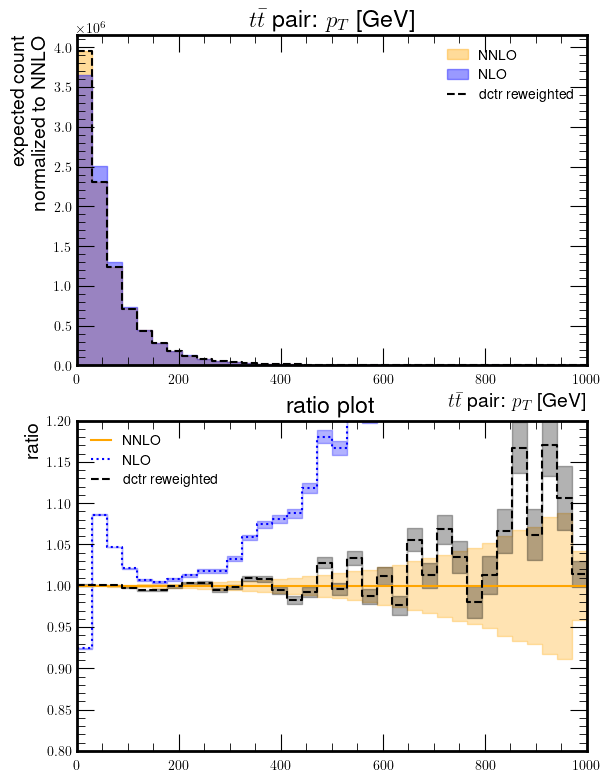

NNLO: mean: 0.000, std: 1.032, max/min: 3.5697566023272644/-3.547147542892114 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: -0.000, std: 1.055, max/min: 3.6291263291592433/-3.6554655461346397 
 Mean Absolute Error 6216.814736796912 
 Mean Relative Error 0.16651193995088706 
 reduced chi square of 80.16522430568439 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 0.000, std: 1.036, max/min: 3.6291263291592433/-3.6554655461346397 
 Mean Absolute Error 1123.3462379925802 
 Mean Relative Error 0.07606630772352219 
 reduced chi square of 3.0564940393213607 with p 8.487676397751137e-09 
 compared to NNLO


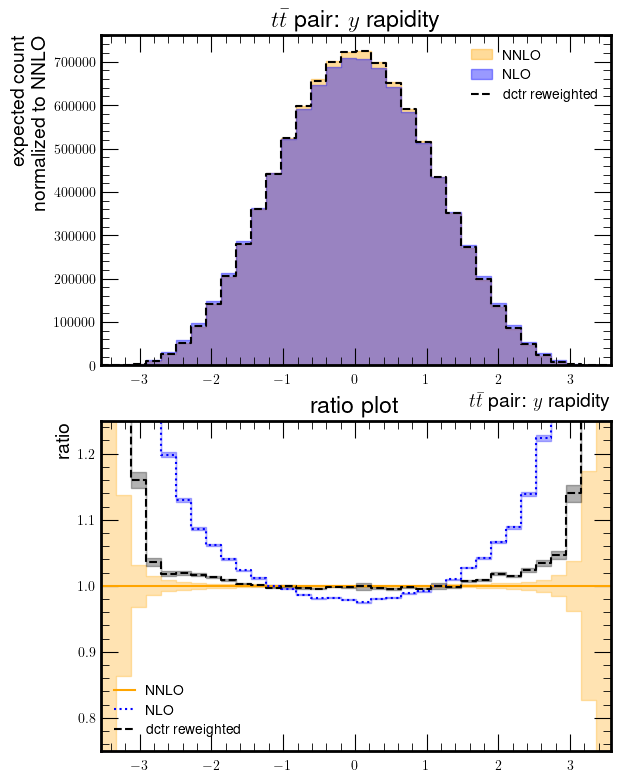

NNLO: mean: 523.184, std: 178.057, max/min: 5626.682794956003/322.9727283915917 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 525.503, std: 180.880, max/min: 5906.588895431482/193.5341411301989 
 Mean Absolute Error 4564.82707412763 
 Mean Relative Error 0.02750746932649318 
 reduced chi square of 29.45074149433414 with p 7.961853328784299e-183 
 compared to NNLO
dctr reweighted: mean: 524.825, std: 181.107, max/min: 5906.588895431482/193.5341411301989 
 Mean Absolute Error 1588.1707391403615 
 Mean Relative Error 0.024068621918559074 
 reduced chi square of 4.062737522563348 with p 3.902202489440353e-14 
 compared to NNLO


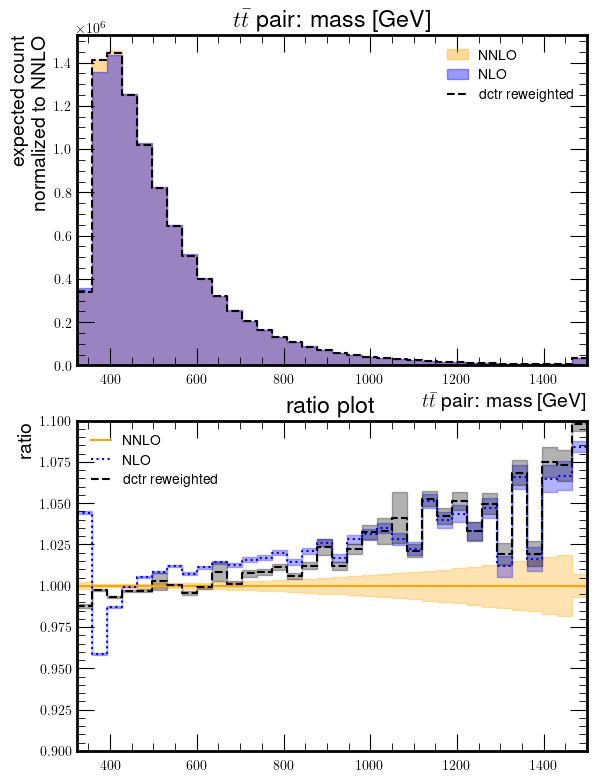

NNLO: mean: 0.001, std: 3.417, max/min: 13.830049878532156/-13.20077537478709 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 0.000, std: 3.300, max/min: 10.248442549964063/-9.925218853905918 
 Mean Absolute Error 14264.308760550268 
 Mean Relative Error 0.8107505726170643 
 reduced chi square of 573.8585808015405 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 0.005, std: 3.425, max/min: 10.248442549964063/-9.925218853905918 
 Mean Absolute Error 1541.7214466168996 
 Mean Relative Error 0.07187851518392563 
 reduced chi square of 1.6902277414419322 with p 0.007883030540938729 
 compared to NNLO


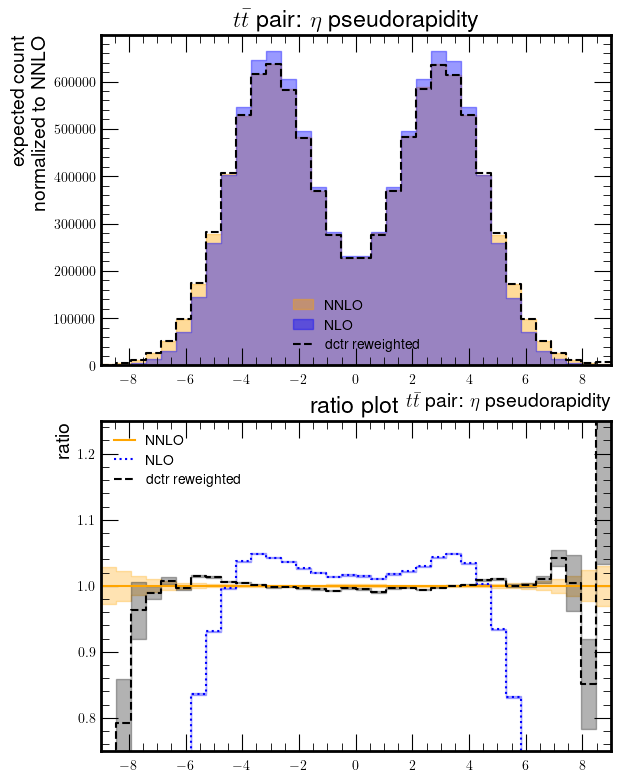

NNLO: mean: 862.694, std: 503.370, max/min: 6492.5814801/329.6132055 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 885.989, std: 537.266, max/min: 6920.394397/218.5203754 
 Mean Absolute Error 7510.618609024198 
 Mean Relative Error 0.06634306802601331 
 reduced chi square of 116.01167201336378 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 868.157, std: 511.143, max/min: 6920.394397/218.5203754 
 Mean Absolute Error 2129.2589123609 
 Mean Relative Error 0.016196945682168007 
 reduced chi square of 5.757573903508091 with p 5.726736048859608e-24 
 compared to NNLO


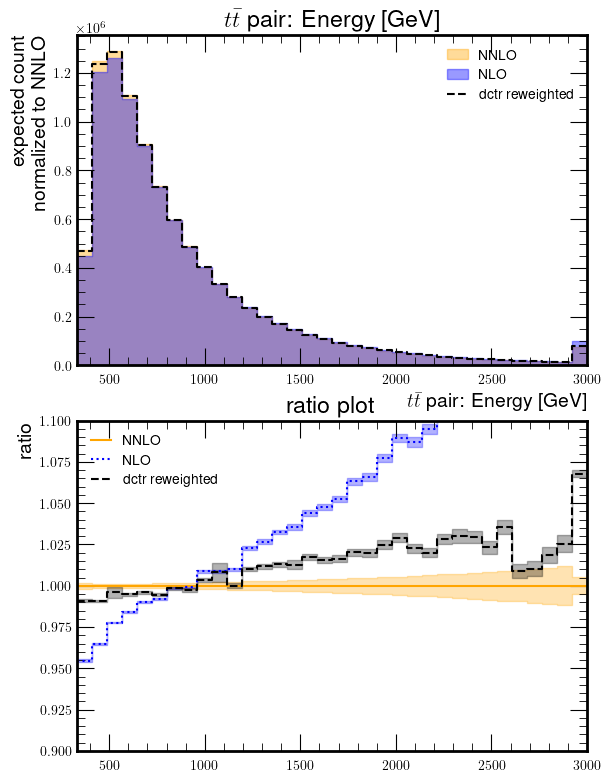

NNLO: mean: 120.981, std: 80.007, max/min: 2125.1621873385748/0.02517621005772228 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 123.912, std: 81.885, max/min: 2904.1747509085008/0.019422190013226173 
 Mean Absolute Error 8324.175851338125 
 Mean Relative Error 0.10811766149022396 
 reduced chi square of 85.36371484122392 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 121.451, std: 80.681, max/min: 2904.1747509085008/0.019422190013226173 
 Mean Absolute Error 1163.5541309832684 
 Mean Relative Error 0.0485629066824913 
 reduced chi square of 2.626854191891417 with p 1.0419049773087034e-06 
 compared to NNLO


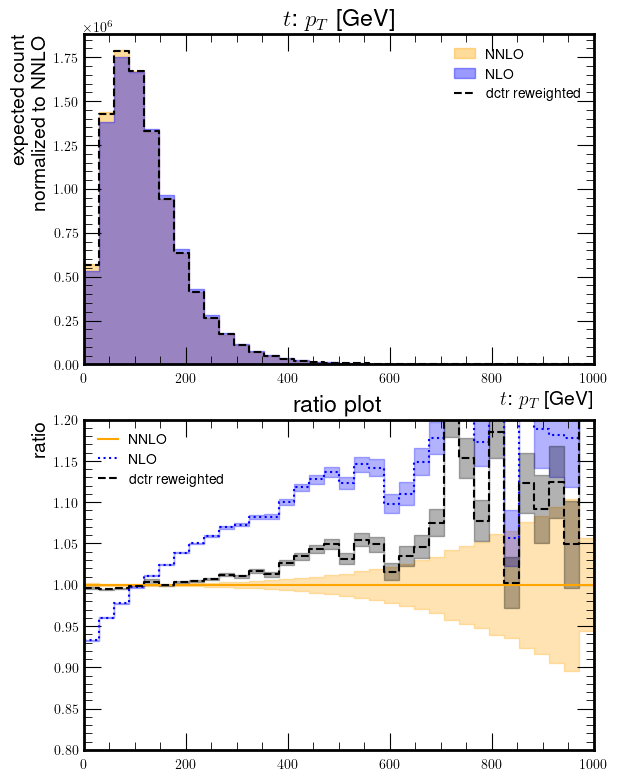

NNLO: mean: 0.000, std: 1.214, max/min: 4.194517128782431/-4.141641811983429 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: -0.000, std: 1.232, max/min: 4.172829694963547/-4.200430213947663 
 Mean Absolute Error 3892.614882703041 
 Mean Relative Error 0.18588546636282827 
 reduced chi square of 37.35248581373054 with p 7.502134510384075e-238 
 compared to NNLO
dctr reweighted: mean: 0.001, std: 1.219, max/min: 4.172829694963547/-4.200430213947663 
 Mean Absolute Error 1253.9285520785008 
 Mean Relative Error 0.18244309723377228 
 reduced chi square of 3.3075014862411085 with p 4.4461651542803955e-10 
 compared to NNLO


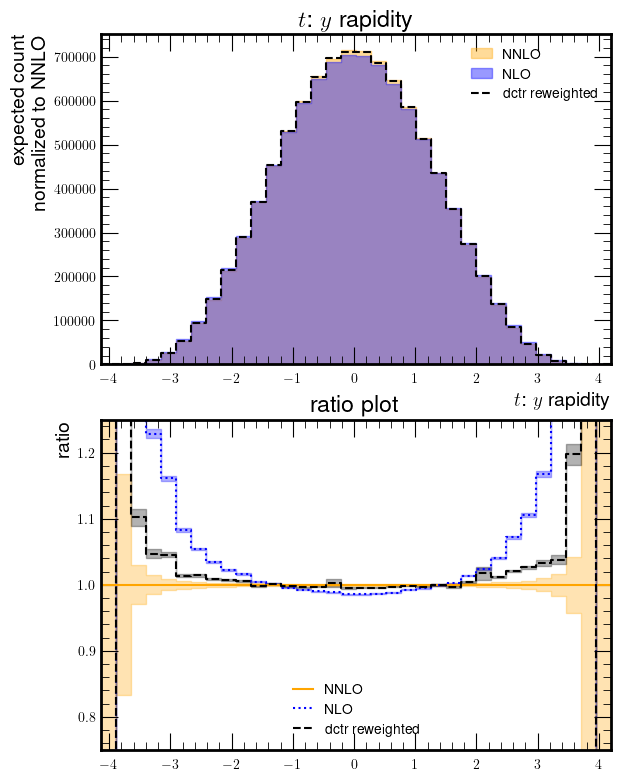

NNLO: mean: 172.341, std: 2.602, max/min: 185.5999802308967/159.40000608638425 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 171.944, std: 6.953, max/min: 243.95111751632527/80.42225936275699 
 Mean Absolute Error 19414.534681349473 
 Mean Relative Error 0.2614515379680497 
 reduced chi square of 3066.126974679554 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 172.334, std: 2.623, max/min: 243.95111751632527/80.42225936275699 
 Mean Absolute Error 984.5520319321556 
 Mean Relative Error 0.016116736456751823 
 reduced chi square of 1.681492235605862 with p 0.00844507476988585 
 compared to NNLO


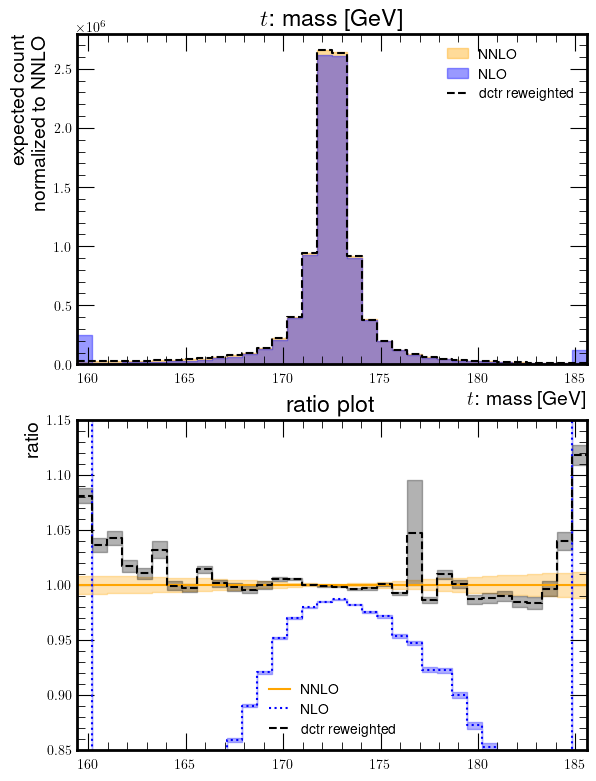

NNLO: mean: 0.001, std: 1.884, max/min: 9.769814493793154/-10.18823770968854 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: -0.000, std: 1.885, max/min: 11.837295548395607/-10.44415574755628 
 Mean Absolute Error 697.7519220255563 
 Mean Relative Error 0.08421224760541808 
 reduced chi square of 0.9840687885173534 with p 0.4931280748194553 
 compared to NNLO
dctr reweighted: mean: 0.001, std: 1.888, max/min: 11.837295548395607/-10.44415574755628 
 Mean Absolute Error 734.6290765077231 
 Mean Relative Error 0.11870080232620239 
 reduced chi square of 0.9508527492268003 with p 0.5479519104042496 
 compared to NNLO


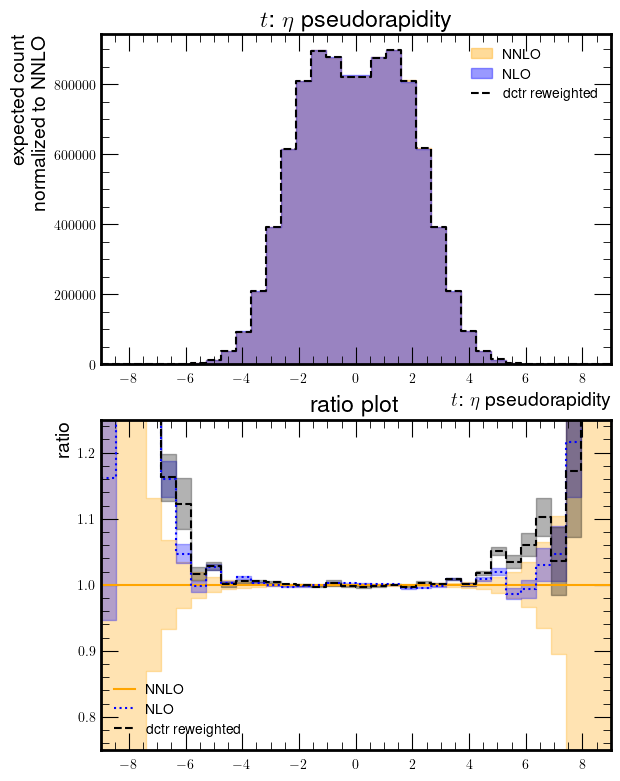

NNLO: mean: 432.960, std: 333.470, max/min: 5996.224969/159.6472363 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 444.149, std: 352.355, max/min: 6027.376185/83.90162087 
 Mean Absolute Error 6084.202058203032 
 Mean Relative Error 0.05562410027238303 
 reduced chi square of 64.28190642330264 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 435.803, std: 338.789, max/min: 6027.376185/83.90162087 
 Mean Absolute Error 1483.4313410768723 
 Mean Relative Error 0.01452528964728117 
 reduced chi square of 3.079172254354365 with p 6.527195764259873e-09 
 compared to NNLO


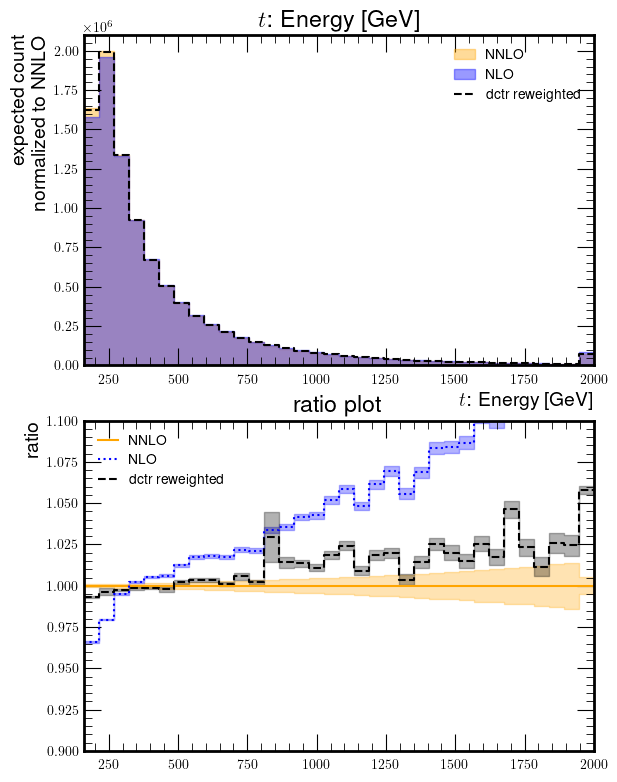

NNLO: mean: 2.646, std: 0.664, max/min: 3.1415926443988056/2.0450538809058116e-06 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 2.636, std: 0.665, max/min: 3.1415926534573932/1.130071720645276e-06 
 Mean Absolute Error 16296.47809976804 
 Mean Relative Error 0.021494242385014812 
 reduced chi square of 230.3927162062576 with p 0.0 
 compared to NNLO
NLO reweighted: mean: 2.648, std: 0.664, max/min: 3.1415926534573932/1.130071720645276e-06 
 Mean Absolute Error 2438.0029212013546 
 Mean Relative Error 0.007979534566402435 
 reduced chi square of 3.1003510389434195 with p 3.7580493446155307e-08 
 compared to NNLO


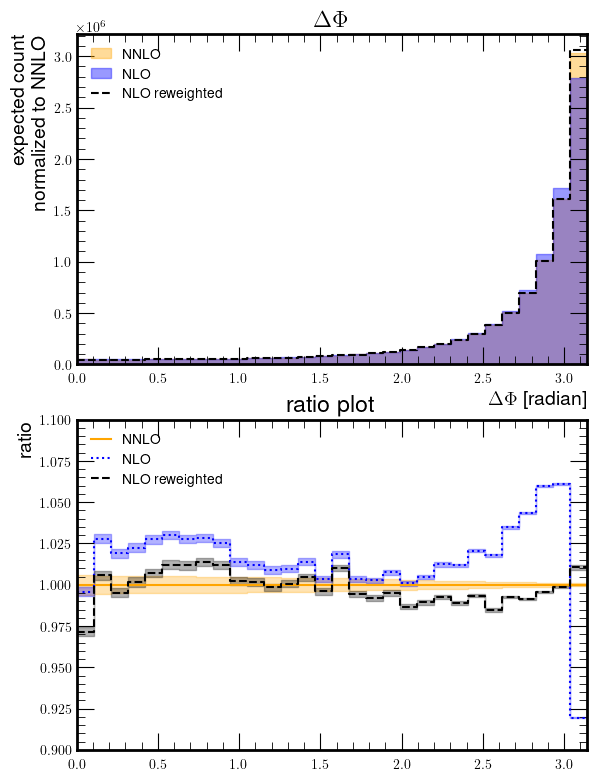

In [13]:
# set up args for passing to plot_ratio()
args = [(X1_test, X1_wgt, 'NNLO'),
        (X0_test, X0_wgt, 'NLO'),
        (X0_test, X0_rwgt, 'dctr reweighted')]

''' plot_ratio() necessary args:
args = [(baseline_data, baseline_wgt, baseline_label), (x0, x0_wgt, x0_label), ...]

default args:
arg_index = 0, part_index = 0, title = None, x_label = None, y_label = None, 
bins = None, start = None, stop = None, div = 35, ratio_ylim=[0.9,1.1],
figsize=(6,8), layout='rows', stats_only=False, y_scale=None, verbose = True

ratio and stats are always calculated in comparison to first passed dataset in args.
first and last bins contain all events that are outside the plotted range.
automatically checks shape of array. If shape is as expected (i.e the datasets were created with my convert_lhe()): 
    will grab the particle and observable from part_index and arg_index, otherwise plots array as is (i.e. when plotting delta phi)
    if title, x_label, y_label = None automatically sets labels and title for plots. If not None, then overrides automatic labels (i.e. for delta phi)
if bins = None; calculates bins according to start, stop and div. If start, stop = None, takes min, max from first dataset in args, otherwise uses passed bins for plotting
y_scale is linear unless y_scale='log' is passed
'''

# which observables and particles to plot
arg_indices = [0, 1, 3, 4, 5]
part_indices = [0, 1]
div = 31

# prep arrays for saving stats, which are analyzed below
mae_all = []
chi2_all = []
p_all = []

# loop over all wanted particles and observables
for part_index in part_indices:
    for arg_index in arg_indices:
        bins = []
        ratio_ylim = [0.75, 1.25]
        if arg_index == 1:  # rapidity
            start = None
            stop = None
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = None
                stop = 1500
                ratio_ylim = [0.90, 1.10]
            else:
                start = None
                stop = None
                ratio_ylim = [0.85, 1.15]
        elif arg_index == 4:  # pseudorapidity
            start = -9
            stop = 9
        elif arg_index == 5: # energy
            ratio_ylim = [0.9, 1.10]
            if part_index == 0:  # tt-pair
                start = None
                stop = 3000
            else:
                start = None
                stop = 2000
        else:  # pt
            ratio_ylim = [0.8, 1.2]
            start = 0
            stop = 1000
        
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args, arg_index=arg_index, part_index=part_index, start = start, stop = stop, ratio_ylim = ratio_ylim)
        # append to list of stats for comparison below
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)



# calculate and plot delta phi
X0_delta_phi = DCTR.delta_phi(X0_test)
X1_delta_phi = DCTR.delta_phi(X1_test)

args_phi = [(X1_delta_phi, X1_wgt, 'NNLO'),
            (X0_delta_phi, X0_wgt, 'NLO'),
            (X0_delta_phi, X0_rwgt, 'NLO reweighted')]

mae_list, chi2_list, p_list = DCTR.plot_ratio(args_phi, title = r'$\Delta \Phi$', x_label = r'$\Delta \Phi$ [radian]', start = 0, stop = math.pi, div = div)
# append to list of stats for comparison below
mae_all.append(mae_list)
chi2_all.append(chi2_list)
p_all.append(p_list)


In [14]:
# mean stats over all histograms
mae_mean = np.mean(mae_all, axis = 0)
chi2_mean = np.mean(chi2_all, axis = 0)
p_mean = np.mean(p_all, axis = 0)

print('[NNLO, NLO, NL0 rwgt]')
print(f'MAE  mean:                {mae_mean}\n')
print(f'reduced chi2 mean:        {chi2_mean}\n')
print(f'p-value (from chi2) mean: {p_mean}\n')


[NNLO, NLO, NL0 rwgt]
MAE  mean:                [   0.         9533.42541424 1348.51946087]

reduced chi2 mean:        [  0.         416.06409072   2.71782516]

p-value (from chi2) mean: [1.         0.04482982 0.13975235]



NNLO: mean: 172.341, std: 2.602, max/min: 185.5999802308967/159.40000608638425 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 171.944, std: 6.953, max/min: 243.95111751632527/80.42225936275699 
 Mean Absolute Error 21202.637710547817 
 Mean Relative Error 0.262556066973902 
 reduced chi square of 3310.32956394389 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 172.334, std: 2.623, max/min: 243.95111751632527/80.42225936275699 
 Mean Absolute Error 1119.7040067969167 
 Mean Relative Error 0.015718061476945877 
 reduced chi square of 1.8479066931974935 with p 0.0031665327242045003 
 compared to NNLO


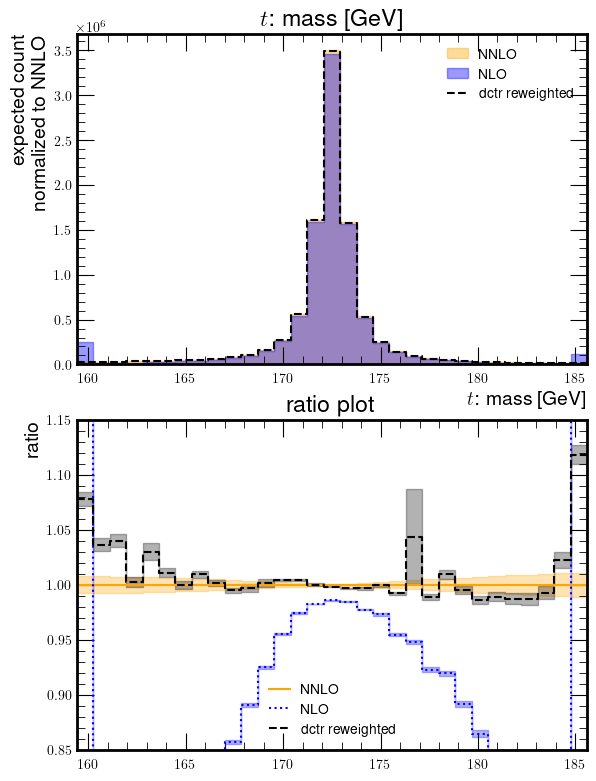

([0.0, 21202.637710547817, 1119.7040067969167],
 [0.0, 3310.32956394389, 1.8479066931974935],
 [1.0, 0.0, 0.0031665327242045003])

In [15]:
# redo mass with better binning

start = None
stop = None
div = 32
ratio_ylim = [0.85, 1.15]

args = [(X1_test, X1_wgt, 'NNLO'),
        (X0_test, X0_wgt, 'NLO'),
        (X0_test, X0_rwgt, 'dctr reweighted')]

DCTR.plot_ratio(args, arg_index=3, part_index=1, start = start, stop = stop, div=div, ratio_ylim = ratio_ylim)
